# Case-by-case analysis
This notebook demonstrates how to visualize which model managed to solve which test-case how often.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
directory = "../data/"

collection = []
for filename in os.listdir(directory):
    if filename.endswith("_results.jsonl"):
        print(filename)
        df = pd.read_json(directory + filename, lines=True)
        df['model'] = filename.replace(".jsonl_results.jsonl", "").replace("samples_", "")
        collection.append(df)

df = pd.concat(collection)

samples_reference.jsonl_results.jsonl


In [3]:
df

,task_id,completion,full_response,result,passed,model
0,../test_cases/apply_otsu_threshold_and_count_p...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
1,../test_cases/binary_closing.ipynb,\n import numpy as np\n import skimage\n...,\n import numpy as np\n import skimage\n...,passed,True,reference
2,../test_cases/binary_skeleton.ipynb,\n from skimage.morphology import skeletoni...,\n from skimage.morphology import skeletoni...,passed,True,reference
3,../test_cases/bland_altman.ipynb,\n import scipy\n data1 = dataframe[colu...,\n import scipy\n data1 = dataframe[colu...,passed,True,reference
4,../test_cases/combine_columns_of_tables.ipynb,\n import pandas as pd\n return pd.merge...,\n import pandas as pd\n return pd.merge...,passed,True,reference
...,...,...,...,...,...,...
109,../test_cases/workflow_batch_process_folder_me...,\n import os\n import pandas as pd\n ...,\n import os\n import pandas as pd\n ...,passed,True,reference
110,../test_cases/workflow_segmentation_counting.i...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
111,../test_cases/workflow_segmentation_measuremen...,\n import skimage\n import numpy as np\n...,\n import skimage\n import numpy as np\n...,passed,True,reference
112,../test_cases/workflow_segment_measure_umap.ipynb,\n import numpy as np\n import pandas as...,\n import numpy as np\n import pandas as...,passed,True,reference


In [4]:
# Ensure the 'passed' column is boolean for correct processing.
df['passed'] = df['passed'].astype(bool)
# shorten task name
df['task_id'] = [str(t).replace("../test_cases/", "").replace(".ipynb","") for t in df['task_id']]

# Pivot the dataframe to count True 'passed' values for each model-task combination.
pivot_df = df.pivot_table(index='task_id', columns='model', values='passed', aggfunc='mean', fill_value=0)

# Reset the index if 'task_id' needs to be a column instead of an index
pivot_df.reset_index(inplace=True)

# Apply formatting to display only two digits after the decimal point for all columns after the first (task_id column)
pivot_df = pivot_df.round(2)

# Show the transformation result (for verification)
def colorize(styler):
    styler.background_gradient(axis=None, cmap="PiYG")
    return styler

# Apply the formatting within the styling function using .format
pivot_df.style.pipe(colorize).format("{:.1f}", subset=pivot_df.columns[1:])

model,task_id,reference
0,apply_otsu_threshold_and_count_postiive_pixels,1.0
1,binary_closing,1.0
2,binary_skeleton,1.0
3,bland_altman,1.0
4,combine_columns_of_tables,1.0
5,convex_hull_measure_area,1.0
6,convolve_images,1.0
7,count_number_of_touching_neighbors,1.0
8,count_objects_over_time,1.0
9,count_overlapping_regions,1.0


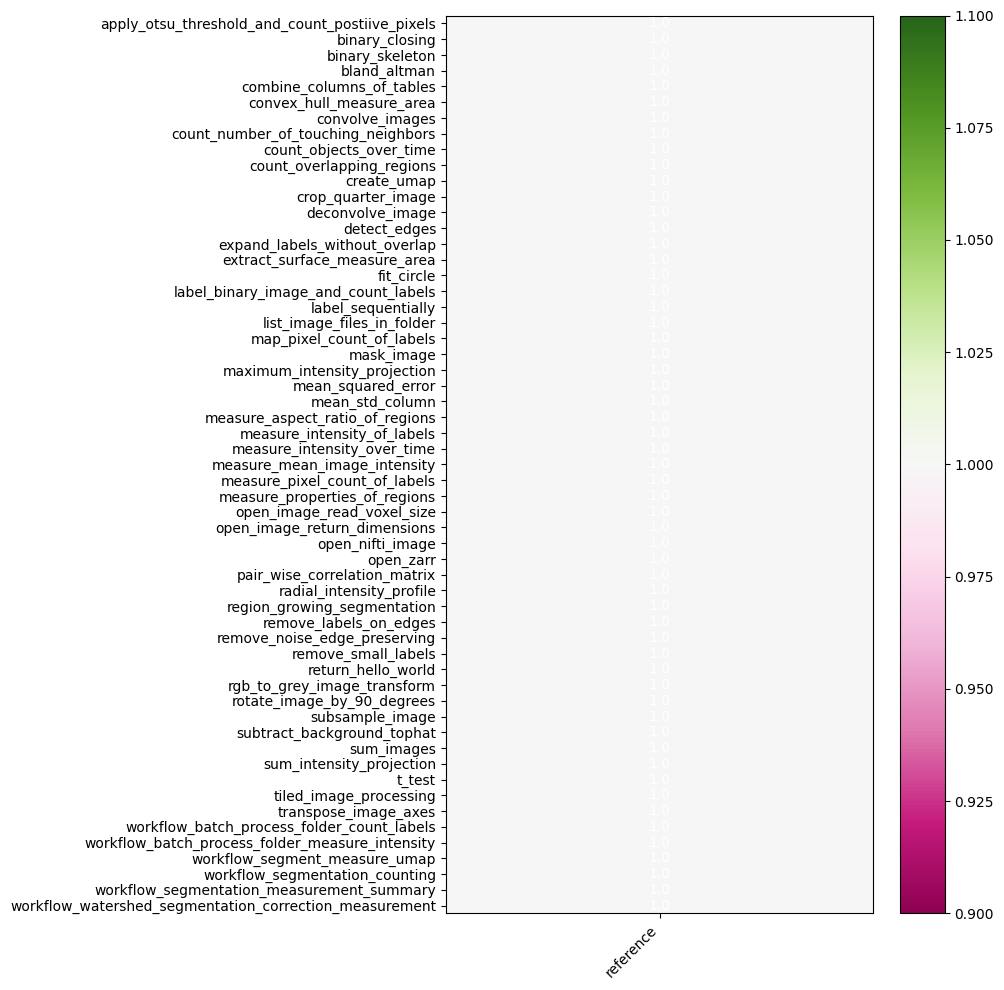

In [5]:
import matplotlib.pyplot as plt
import numpy as np

df = pivot_df

# Separate the numerical data for plotting and the string column for y-axis labels
numerical_data = df.select_dtypes(include=[np.number])
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
numerical_data = numerical_data[mean_values.index]

str_column_values = df['task_id']  # Replace 'str_column' with the actual column name

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
cax = ax.imshow(numerical_data, cmap='PiYG', aspect='auto')

# Annotating each cell with the corresponding value
for (i, j), val in np.ndenumerate(numerical_data):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')

# Setting the column names as x-axis labels
ax.set_xticks(np.arange(len(numerical_data.columns)))
ax.set_xticklabels(numerical_data.columns)

# Setting the string column values as y-axis labels
ax.set_yticks(np.arange(len(str_column_values)))
ax.set_yticklabels(str_column_values)

# Rotating the tick labels for better visibility
plt.xticks(rotation=45, ha="right")

# Showing the color bar and tight_layout for neatness
fig.colorbar(cax)
plt.tight_layout()

plt.savefig("performance_per_task")
plt.show()

In [6]:
pivot_df.describe()

model,reference
count,57.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


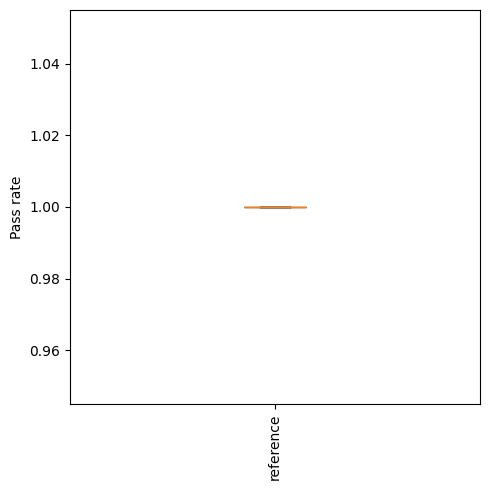

In [7]:
# Assuming pivot_df has 'task_id' as a non-numerical column and the rest are numerical and need to be plotted
numerical_data = pivot_df.drop(columns=['task_id'])

# Calculate the mean of each column and sort these means in descending order
mean_values = numerical_data.mean().sort_values(ascending=False)

# Reorder columns in numerical_data based on sorted mean values
ordered_numerical_data = numerical_data[mean_values.index]

# Plotting the boxplot with reordered columns
plt.figure(figsize=(5, 5))
boxplot = plt.boxplot(ordered_numerical_data, patch_artist=True, labels=ordered_numerical_data.columns)

# Adding colors
# colors = ['lightblue'] * len(ordered_numerical_data.columns)
#for patch, color in zip(boxplot['boxes'], colors):
#    patch.set_facecolor(color)

# plt.title('Pass rate for generated BIA Python code')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.ylabel('Pass rate')  # Optionally adjust the label to suit the data context
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()